#Fragestellug
Welcher RNN Layer ist bei Klassifikation am besten? <br>
**Parameter:**
* Textrepräsentation = POS-Embedding
* Problemdefinition = Klassifikation
* Reccurent-Layer = nur RNN Layer


In [1]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [2]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter

#Setup

In [3]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 50 # make the top list of words (common words)
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 150
batch_size = 20
no_epochs = 10
verbosity = 0

##Funktionen

In [4]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_conf_matrix(_conf_matrix,_labels):
  disp = ConfusionMatrixDisplay(confusion_matrix=_conf_matrix,
                                display_labels=_labels)
  disp = disp.plot(include_values=True,
                  cmap='viridis', ax=None, xticks_rotation='vertical')
  plt.show()

#Daten aufbereiten

In [5]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)
texts = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/texts.xlsx',index_col=0)

In [6]:
labels.sort_values(by=['id'],inplace=True)
texts.sort_values(by=['id'],inplace=True)

In [7]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [8]:
l_labels = labels['cerf_rating'].to_list()
l_texts = texts['text'].to_list()

In [9]:
print(len(l_labels))
print(len(l_texts))

1033
1033


In [10]:
################ Texte aufbereiten #########################
#Texte in Spacy Dokumente umwandeln
l_docs = []
nlp = spacy.load("de_core_news_lg")
for text in tqdm(nlp.pipe(l_texts)):
    l_docs.append(text)

#Texte in POS umwandeln
l_pos_texts = []
for doc in tqdm(l_docs):
  l_pos = []
  for token in doc:
    l_pos.append(token.tag_)
  pos_string = ' '.join(l_pos)
  l_pos_texts.append(pos_string)

#Vokabular mit Tokenizer erstellen
word_index = {}
i = 1
for doc in l_docs:
  for token in doc:
    if token.tag_ not in word_index:
      word_index[token.tag_] = i
      i += 1

#texte mit Index in Zahlensequenz umwandeln
text_seqs = []
for doc in l_docs:
  seq = []
  for token in doc:
    seq.append(word_index[token.tag_])
  text_seqs.append(seq)

#Zahlenequenzen auf gleiche Läng bringen
input = pad_sequences(text_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

1033it [00:13, 78.97it/s]
100%|██████████| 1033/1033 [00:00<00:00, 17726.45it/s]


In [11]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

#Vergleich der verschiedenen Reccurent Layern

##Regression

###LSTM

In [12]:
#Architektur 4
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(LSTM(embedding_dim))
  model.add(Dense(1, activation='linear'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='mean_absolute_error',
      optimizer=opt,
      metrics=[tf.keras.metrics.MeanSquaredError()],
  )
  return model

In [13]:
int_sequence = convert_to_int(target)
target = int_sequence[0]
tokenizer = int_sequence[1]

In [14]:
################# Training des Modells #####################
#Benennung
architecture = 'LSTM (Re)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    y_train = target[train]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_regression(x_test,y_test)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')

    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.789580171977744
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7968343017431376
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7239225484072455
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7912087912087913
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7649236699295024
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score: 0.7345908060193775
Acc Score: 57.28155339805825%
-----------------------------------------------

  3%|▎         | 1/30 [01:11<34:47, 71.97s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7569202521827796
Acc Score: 60.01026885735624%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8029713829893309
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6685714285714286
Acc Score: 52.88461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7912087912087913
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7772399588053553
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Trainin

  7%|▋         | 2/30 [02:16<31:35, 67.70s/it]

Kappa Score: 0.7474458520637515
Acc Score: 53.398058252427184%
Kappa Score: 0.7499024739514054
Acc Score: 59.432412247946225%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7629025999223904
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7909278350515464
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.707493101252388
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7578060917591731
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7410537576892218
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Traini

 10%|█         | 3/30 [03:20<29:41, 65.96s/it]

Kappa Score: 0.7579689415610953
Acc Score: 55.33980582524271%
Kappa Score: 0.7483723121839826
Acc Score: 59.72460791635549%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7855006703104053
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.801107196779064
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7144064216307562
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.793303760033798
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7683940804267113
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training 

 13%|█▎        | 4/30 [04:24<28:12, 65.10s/it]

Kappa Score: 0.7438217706514261
Acc Score: 54.36893203883495%
Kappa Score: 0.7568638037780467
Acc Score: 60.01026885735624%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7607205795966321
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7645790665085695
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7503575076608784
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7844378856989536
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7707675586149785
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 .

 17%|█▋        | 5/30 [05:27<26:53, 64.56s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7537244109815703
Acc Score: 59.81889469753548%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7950290156575057
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7968343017431376
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7526816433920259
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7760513337222251
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 20%|██        | 6/30 [06:32<25:51, 64.65s/it]

Kappa Score: 0.7449179651222784
Acc Score: 53.398058252427184%
Kappa Score: 0.7564465072703966
Acc Score: 60.48823749066467%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7629025999223904
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8025451559934318
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7103216312802186
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7602965849434432
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7216494845360825
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Train

 23%|██▎       | 7/30 [07:36<24:38, 64.29s/it]

Kappa Score: 0.7474458520637515
Acc Score: 53.398058252427184%
Kappa Score: 0.739082148191641
Acc Score: 57.783793876026884%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7811986863711001
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.801107196779064
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7503575076608784
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7693829731840667
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.770672603945529
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Trainin

 27%|██▋       | 8/30 [08:39<23:29, 64.07s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7517198791963695
Acc Score: 59.03566094100074%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7811986863711001
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7867956265769553
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6685714285714286
Acc Score: 52.88461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7616413614043009
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Trainin

 30%|███       | 9/30 [09:47<22:47, 65.13s/it]

Kappa Score: 0.7438217706514261
Acc Score: 54.36893203883495%
Kappa Score: 0.7419998938089241
Acc Score: 58.75560119492158%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7938605407603171
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.801107196779064
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7531645569620253
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7740048061853516
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7683940804267113
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 ..

 33%|███▎      | 10/30 [10:53<21:49, 65.46s/it]

Kappa Score: 0.7390117922229802
Acc Score: 55.33980582524271%
Kappa Score: 0.7572362171021045
Acc Score: 60.29686333084391%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7958115183246073
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7945273140373407
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.742879746835443
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7760513337222251
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training 

 37%|███▋      | 11/30 [11:56<20:26, 64.57s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7605275832510454
Acc Score: 60.397684839432415%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7913531949042031
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7373737373737373
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7717391304347826
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7359118433255141
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training

 40%|████      | 12/30 [12:59<19:16, 64.25s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7431900256511469
Acc Score: 58.072255414488424%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7768940979489326
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.801107196779064
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7373737373737373
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7760513337222251
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7683940804267113
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Traini

 43%|████▎     | 13/30 [14:05<18:22, 64.86s/it]

Kappa Score: 0.7464250170237284
Acc Score: 54.36893203883495%
Kappa Score: 0.7564466338261182
Acc Score: 59.81702763256161%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7946199829205807
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7968343017431376
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7373737373737373
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7756724382010236
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.764228488190615
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training f

 47%|████▋     | 14/30 [15:09<17:10, 64.41s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7587349094341077
Acc Score: 59.9113144137416%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7867956265769553
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7171548117154811
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7846228084285025
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7640320733104238
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training f

 50%|█████     | 15/30 [16:14<16:08, 64.59s/it]

Kappa Score: 0.7479787234042553
Acc Score: 55.33980582524271%
Kappa Score: 0.74865922836715
Acc Score: 59.3306572068708%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7629025999223904
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987296546248511
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7526816433920259
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7684873005169701
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7683940804267113
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training f

 53%|█████▎    | 16/30 [17:19<15:04, 64.63s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7481303065124792
Acc Score: 59.3306572068708%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7834010205144226
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.797270955165692
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7526816433920259
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.755976739177256
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training f

 57%|█████▋    | 17/30 [18:24<14:02, 64.85s/it]

Kappa Score: 0.7581763581763582
Acc Score: 58.252427184466015%
Kappa Score: 0.7545986222638094
Acc Score: 60.393950709484685%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7768940979489326
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7867956265769553
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7526816433920259
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7912087912087913
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Traini

 60%|██████    | 18/30 [19:27<12:52, 64.38s/it]

Kappa Score: 0.7438217706514261
Acc Score: 54.36893203883495%
Kappa Score: 0.7595488431381642
Acc Score: 60.39581777445855%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7855006703104053
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8029713829893309
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7171548117154811
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7760513337222251
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7649236699295024
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 63%|██████▎   | 19/30 [20:33<11:54, 64.94s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7527672235275948
Acc Score: 60.01026885735624%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7855006703104053
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.792934449663059
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6658399098083427
Acc Score: 50.96153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7526665549785001
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 67%|██████▋   | 20/30 [21:38<10:48, 64.88s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7448511617931243
Acc Score: 58.659447348767735%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7909278350515464
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.754962903549228
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7550081928220308
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7772399588053553
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Traini

 70%|███████   | 21/30 [22:45<09:50, 65.62s/it]

Kappa Score: 0.7514759484573129
Acc Score: 54.36893203883495%
Kappa Score: 0.7516605685063988
Acc Score: 59.03472740851382%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7881873727087576
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.742879746835443
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7717391304347826
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7634965557750841
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 ..

 73%|███████▎  | 22/30 [23:48<08:36, 64.57s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7549631244598891
Acc Score: 59.71994025392083%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.799163179916318
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7438704028021015
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7462383082553883
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.786613545816733
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7772399588053553
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training for fold 6 ...


 77%|███████▋  | 23/30 [24:52<07:32, 64.59s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7544448880975434
Acc Score: 59.912247946228526%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7629025999223904
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7867956265769553
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7212528904771915
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.754711120314765
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7768560105680318
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Traini

 80%|████████  | 24/30 [25:57<06:27, 64.57s/it]

Kappa Score: 0.7514759484573129
Acc Score: 54.36893203883495%
Kappa Score: 0.7499737843468968
Acc Score: 59.33439133681852%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7901221455124801
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7922837100545597
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7144064216307562
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7650096061479347
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 83%|████████▎ | 25/30 [27:04<05:26, 65.40s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7499152786233833
Acc Score: 59.71994025392083%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7768940979489326
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987296546248511
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7462383082553883
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7672744469549682
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7707675586149785
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 

 87%|████████▋ | 26/30 [28:10<04:22, 65.67s/it]

Kappa Score: 0.7421777221526908
Acc Score: 53.398058252427184%
Kappa Score: 0.7495251747639395
Acc Score: 59.03752800597461%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7956057246522878
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987296546248511
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7103216312802186
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7782852942720638
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7683940804267113
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Train

 90%|█████████ | 27/30 [29:15<03:16, 65.41s/it]

Kappa Score: 0.7449179651222784
Acc Score: 53.398058252427184%
Kappa Score: 0.75099136611276
Acc Score: 59.33159073935773%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7856689917564997
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7947300898055857
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6863420939250323
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7651813471502591
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7749453750910416
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training

 93%|█████████▎| 28/30 [30:23<02:12, 66.01s/it]

Kappa Score: 0.7423389618511569
Acc Score: 53.398058252427184%
Kappa Score: 0.7492529502296053
Acc Score: 58.94697535474234%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7855006703104053
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.801107196779064
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7526816433920259
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7622031662269129
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7794882250993985
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Training 

 97%|█████████▋| 29/30 [31:29<01:06, 66.06s/it]

Kappa Score: 0.7489758879958517
Acc Score: 54.36893203883495%
Kappa Score: 0.7540515585000445
Acc Score: 59.71433905899925%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7875600040853845
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987296546248511
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7503575076608784
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7662632375189108
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.737579617834395
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Training 

100%|██████████| 30/30 [32:33<00:00, 65.13s/it]

Kappa Score: 0.7386229064456098
Acc Score: 56.310679611650485%
Kappa Score: 0.7532057371535059
Acc Score: 59.81235997012696%


In [16]:
model_4 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_4

{'acc': 59.54132437142146,
 'acc_std': 0.6668246542080515,
 'konfig': 'LSTM (Re)',
 'qwk': 0.7519235622401975,
 'qwk_std': 0.005196399424680801,
 'z_acc_per_fold': [60.01026885735624,
  59.432412247946225,
  59.72460791635549,
  60.01026885735624,
  59.81889469753548,
  60.48823749066467,
  57.783793876026884,
  59.03566094100074,
  58.75560119492158,
  60.29686333084391,
  60.397684839432415,
  58.072255414488424,
  59.81702763256161,
  59.9113144137416,
  59.3306572068708,
  59.3306572068708,
  60.393950709484685,
  60.39581777445855,
  60.01026885735624,
  58.659447348767735,
  59.03472740851382,
  59.71994025392083,
  59.912247946228526,
  59.33439133681852,
  59.71994025392083,
  59.03752800597461,
  59.33159073935773,
  58.94697535474234,
  59.71433905899925,
  59.81235997012696],
 'z_qwk_per_fold': [0.7569202521827796,
  0.7499024739514054,
  0.7483723121839826,
  0.7568638037780467,
  0.7537244109815703,
  0.7564465072703966,
  0.739082148191641,
  0.7517198791963695,
  0.74199

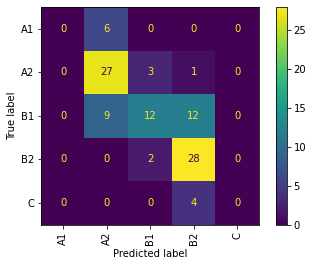

In [17]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

###GRU

In [18]:
#Architektur 5
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(embedding_dim))
  model.add(Dense(1, activation='linear'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='mean_absolute_error',
      optimizer=opt,
      metrics=[tf.keras.metrics.MeanSquaredError()],
  )
  return model

In [19]:
int_sequence = convert_to_int(target)
target = int_sequence[0]
tokenizer = int_sequence[1]

In [20]:
################# Training des Modells #####################
#Benennung
architecture = 'GRU (Re)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    y_train = target[train]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_regression(x_test,y_test)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')

    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7994643813604714
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8018837972272198
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7537666810159277
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7833304906475638
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7466741196198994
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score: 0.7920053849738518
Acc Score: 65.0485436893204%
-----------------------------------------------

  3%|▎         | 1/30 [01:03<30:40, 63.47s/it]

Kappa Score: 0.7561080615649554
Acc Score: 57.28155339805825%
Kappa Score: 0.7674689535765371
Acc Score: 61.94454817027633%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7923143350604491
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7994643813604714
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7518557794273595
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7788700564971751
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6528295192478268
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training

  7%|▋         | 2/30 [02:08<29:58, 64.22s/it]

Kappa Score: 0.7292817679558011
Acc Score: 52.42718446601942%
Kappa Score: 0.7425741912586304
Acc Score: 59.4193427931292%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8106052490626674
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7994643813604714
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7191977077363897
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7923619666256019
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7350408231741417
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training f

 10%|█         | 3/30 [03:12<28:50, 64.10s/it]

Kappa Score: 0.7572154418312294
Acc Score: 56.310679611650485%
Kappa Score: 0.7616537775247125
Acc Score: 60.58812546676624%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7848504137492043
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7976015148327372
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7259552042160737
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7857142857142857
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6516204415472604
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6 

 13%|█▎        | 4/30 [04:16<27:53, 64.35s/it]

Kappa Score: 0.7703334041197707
Acc Score: 59.22330097087378%
Kappa Score: 0.7542390185404989
Acc Score: 61.463778939507094%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8006571741511501
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987984930251502
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.74
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7921757650487613
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7540127742293807
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 6 ..

 17%|█▋        | 5/30 [05:20<26:40, 64.04s/it]

Kappa Score: 0.7576988879384089
Acc Score: 57.28155339805825%
Kappa Score: 0.7650537193774549
Acc Score: 61.65608663181479%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.805950036280709
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.800106780565937
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.755868544600939
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.678105276058582
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7654752449033624
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training f

 20%|██        | 6/30 [06:24<25:36, 64.04s/it]

Kappa Score: 0.768860867706775
Acc Score: 59.22330097087378%
Kappa Score: 0.7635641883862792
Acc Score: 61.264936519790886%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8058045241143833
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7987984930251502
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7843929406761642
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.750202101859337
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7756724382010236
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training

 23%|██▎       | 7/30 [07:28<24:32, 64.02s/it]

Kappa Score: 0.7517008624845984
Acc Score: 56.310679611650485%
Kappa Score: 0.7679103651277215
Acc Score: 61.555265123226285%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8018837972272198
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8113853904282116
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7263157894736842
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8081287044877222
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7486578818936066
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 6

 27%|██▋       | 8/30 [08:34<23:41, 64.63s/it]

Kappa Score: 0.7464250170237285
Acc Score: 54.36893203883495%
Kappa Score: 0.7693833223363815
Acc Score: 61.65702016430172%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.780335832717288
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8113853904282116
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.783564567769477
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7719114219114219
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7682001360757837
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training 

 30%|███       | 9/30 [09:39<22:41, 64.84s/it]

Kappa Score: 0.7481115156784958
Acc Score: 56.310679611650485%
Kappa Score: 0.7669126046987289
Acc Score: 61.06982823002241%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8042455296455087
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8134824348559975
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.755868544600939
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7810227145574578
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.765276379246383
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training f

 33%|███▎      | 10/30 [10:42<21:26, 64.34s/it]

Kappa Score: 0.7462655275433723
Acc Score: 54.36893203883495%
Kappa Score: 0.7692151972718083
Acc Score: 62.03976848394324%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7795243019648397
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8068350668647846
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.718492854049372
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6341030195381883
Acc Score: 48.54368932038835%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7355141230322653
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training

 37%|███▋      | 11/30 [11:47<20:23, 64.42s/it]

Kappa Score: 0.7502372166578809
Acc Score: 55.33980582524271%
Kappa Score: 0.7437360196985969
Acc Score: 58.84428678117998%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.80209324452902
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7955801104972375
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7299447513812155
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7789821182943604
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7425715079144681
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training f

 40%|████      | 12/30 [12:51<19:16, 64.26s/it]

Kappa Score: 0.7443617136074242
Acc Score: 55.33980582524271%
Kappa Score: 0.7596010568511343
Acc Score: 60.88032113517551%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7832870271425518
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7998931052912881
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7799407532797291
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7857142857142857
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7498515840034541
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training 

 43%|████▎     | 13/30 [13:54<18:06, 63.91s/it]

Kappa Score: 0.7513812154696132
Acc Score: 56.310679611650485%
Kappa Score: 0.7665741688440123
Acc Score: 60.77856609410007%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7982975972416766
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8091442953020135
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7487652995490659
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7857142857142857
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7386363636363636
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Trainin

 47%|████▋     | 14/30 [14:58<17:02, 63.92s/it]

Kappa Score: 0.7609452473889651
Acc Score: 57.28155339805825%
Kappa Score: 0.7569920077051876
Acc Score: 61.16504854368932%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.795593255404986
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7819706498951782
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7521711501800467
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7901290468643876
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6975214378010102
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training f

 50%|█████     | 15/30 [16:03<16:05, 64.34s/it]

Kappa Score: 0.7556539617270283
Acc Score: 56.310679611650485%
Kappa Score: 0.7530227486629183
Acc Score: 60.78416728902166%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7882205513784462
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.796225636794885
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7191977077363897
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7839160839160839
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7321953425276961
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training

 53%|█████▎    | 16/30 [17:08<15:02, 64.43s/it]

Kappa Score: 0.7587822014051522
Acc Score: 57.28155339805825%
Kappa Score: 0.757585707984119
Acc Score: 60.68894697535474%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7908773415176209
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8048577087459606
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7263157894736842
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7788700564971751
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7611528268551236
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 6 ...

 57%|█████▋    | 17/30 [18:12<13:57, 64.46s/it]

Kappa Score: 0.7502372166578809
Acc Score: 55.33980582524271%
Kappa Score: 0.7701350071835298
Acc Score: 62.04723674383869%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8016739061341244
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8058134840532902
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7822632596091905
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7879125159997774
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7100293255131964
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training

 60%|██████    | 18/30 [19:16<12:51, 64.26s/it]

Kappa Score: 0.7300720681371478
Acc Score: 53.398058252427184%
Kappa Score: 0.762463880482875
Acc Score: 61.55526512322629%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7875549968573224
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6478413351070262
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.749012724879333
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7812185578535495
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7011374187558032
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training

 63%|██████▎   | 19/30 [20:20<11:45, 64.15s/it]

Kappa Score: 0.7479471423133395
Acc Score: 56.310679611650485%
Kappa Score: 0.7428308528534168
Acc Score: 60.59559372666169%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7950575202386025
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7657393850658858
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7258446309446955
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7623442547300415
Acc Score: 61.165048543689316%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7803135331129359
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Trainin

 67%|██████▋   | 20/30 [21:23<10:36, 63.67s/it]

Kappa Score: 0.7557926500700507
Acc Score: 57.28155339805825%
Kappa Score: 0.7598312047221899
Acc Score: 60.78603435399552%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8002195389681668
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7942309694887014
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7008849557522123
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7916151511745533
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7425715079144681
Acc Score: 62.13592233009708%
------------------------------------------------------------------------
Training 

 70%|███████   | 21/30 [22:28<09:37, 64.16s/it]

Kappa Score: 0.7502372166578809
Acc Score: 55.33980582524271%
Kappa Score: 0.7596209407643664
Acc Score: 60.982076176250935%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7944438344130889
Acc Score: 68.26923076923077%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.805026347790839
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7191977077363897
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7942938659058488
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7541220229834009
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training

 73%|███████▎  | 22/30 [23:31<08:31, 63.88s/it]

Kappa Score: 0.7580093976932935
Acc Score: 57.28155339805825%
Kappa Score: 0.7702032835446588
Acc Score: 62.52987303958178%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7610764686576961
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7976434980002162
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7417788567645112
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7945478723404256
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7541220229834009
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score

 77%|███████▋  | 23/30 [24:35<07:26, 63.82s/it]

Kappa Score: 0.7581643543223052
Acc Score: 57.28155339805825%
Kappa Score: 0.7661480260668936
Acc Score: 61.56273338312173%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7803768680961664
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7900480139676997
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7290490664350846
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7925478348439073
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7011374187558032
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 6 ..

 80%|████████  | 24/30 [25:39<06:23, 63.84s/it]

Kappa Score: 0.7594634225818715
Acc Score: 58.252427184466015%
Kappa Score: 0.7619763655916607
Acc Score: 61.56086631814787%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7955801104972375
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6697819314641744
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7494110087813236
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7943655723158829
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7497791519434629
Acc Score: 63.10679611650486%
------------------------------------------------------------------------
Trainin

 83%|████████▎ | 25/30 [26:42<05:18, 63.64s/it]

Kappa Score: 0.7462655275433723
Acc Score: 54.36893203883495%
Kappa Score: 0.7533026063072024
Acc Score: 60.98300970873787%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.778745299821888
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.798238255033557
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7220161466288457
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.8060485021398003
Acc Score: 67.96116504854369%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7242066883153877
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training f

 87%|████████▋ | 26/30 [27:47<04:16, 64.11s/it]

Kappa Score: 0.7491319894284085
Acc Score: 54.36893203883495%
Kappa Score: 0.7551400996574388
Acc Score: 60.109223300970875%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7824950329394541
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.795144804088586
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7486818980667839
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7925478348439073
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7651768198929008
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training 

 90%|█████████ | 27/30 [28:51<03:12, 64.03s/it]

Kappa Score: 0.7502372166578809
Acc Score: 55.33980582524271%
Kappa Score: 0.7706133579597388
Acc Score: 62.431852128454075%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7600720234076075
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7940698619008936
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7521711501800467
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7945478723404256
Acc Score: 65.0485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.755976739177256
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training for fold 6 ..

 93%|█████████▎| 28/30 [29:54<02:07, 63.62s/it]

Kappa Score: 0.7481115156784958
Acc Score: 56.310679611650485%
Kappa Score: 0.7584962291036033
Acc Score: 60.882188200149365%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8040406155134513
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.8042455296455087
Acc Score: 65.38461538461539%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.755868544600939
Acc Score: 66.34615384615384%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7867999290318766
Acc Score: 66.01941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.750330542089026
Acc Score: 60.19417475728155%
------------------------------------------------------------------------
Training

 97%|█████████▋| 29/30 [30:58<01:03, 63.91s/it]

Kappa Score: 0.7216216216216216
Acc Score: 56.310679611650485%
Kappa Score: 0.7644393959084576
Acc Score: 61.167849141150114%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.8075541526069446
Acc Score: 67.3076923076923%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7928509905254091
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7303023615096005
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7819419808891687
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7624819005738188
Acc Score: 64.07766990291263%
------------------------------------------------------------------------
Trainin

100%|██████████| 30/30 [32:03<00:00, 64.13s/it]

Kappa Score: 0.7650273224043715
Acc Score: 58.252427184466015%
Kappa Score: 0.768595499592408
Acc Score: 62.23767737117252%


In [21]:
model_5 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_5

{'acc': 61.17438386855863,
 'acc_std': 0.8110241650720078,
 'konfig': 'GRU (Re)',
 'qwk': 0.7609761265861054,
 'qwk_std': 0.008065096152855703,
 'z_acc_per_fold': [61.94454817027633,
  59.4193427931292,
  60.58812546676624,
  61.463778939507094,
  61.65608663181479,
  61.264936519790886,
  61.555265123226285,
  61.65702016430172,
  61.06982823002241,
  62.03976848394324,
  58.84428678117998,
  60.88032113517551,
  60.77856609410007,
  61.16504854368932,
  60.78416728902166,
  60.68894697535474,
  62.04723674383869,
  61.55526512322629,
  60.59559372666169,
  60.78603435399552,
  60.982076176250935,
  62.52987303958178,
  61.56273338312173,
  61.56086631814787,
  60.98300970873787,
  60.109223300970875,
  62.431852128454075,
  60.882188200149365,
  61.167849141150114,
  62.23767737117252],
 'z_qwk_per_fold': [0.7674689535765371,
  0.7425741912586304,
  0.7616537775247125,
  0.7542390185404989,
  0.7650537193774549,
  0.7635641883862792,
  0.7679103651277215,
  0.7693833223363815,
  0.76

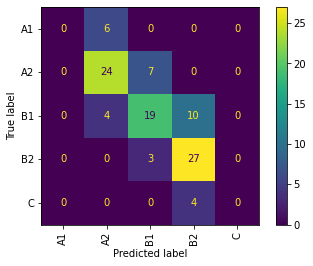

In [22]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

###RNN

In [23]:
#Architektur 6
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(SimpleRNN(embedding_dim))
  model.add(Dense(1, activation='linear'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='mean_absolute_error',
      optimizer=opt,
      metrics=[tf.keras.metrics.MeanSquaredError()],
  )
  return model

In [24]:
int_sequence = convert_to_int(target)
target = int_sequence[0]
tokenizer = int_sequence[1]

In [25]:
################# Training des Modells #####################
#Benennung
architecture = 'RNN (Re)'
great_acc = []
great_kappa = []
for i in tqdm(range(30)):
  #K-Fold Evaluation
  fold_no = 1
  kappa_per_fold = []
  acc_per_fold = []
  conf_per_fold =[]
  for train, test in kfold.split(input, target):
    x_train = input[train]
    x_test = input[test]

    #Zielvariablen in One Hot Repräsentation umwandeln
    y_train = target[train]
    y_test = target[test]

    #Modell aufrufen und kompilieren
    model = knn_model()

    # Makierung für Start des neuen Durchgangs
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Training
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)

    # Auswertung
    score = model_evaluation_regression(x_test,y_test)
    kappa = score['kappa score']
    acc = score['accuracy']
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
    conf_per_fold.append(score['confusion matrix'])
    print(f'Kappa Score: {kappa}')
    print(f'Acc Score: {acc}%')

    # Fold erhöhen
    fold_no = fold_no + 1
  print(f'Kappa Score: {mean(kappa_per_fold)}')
  print(f'Acc Score: {mean(acc_per_fold)}%')
  great_acc.append(mean(acc_per_fold))
  great_kappa.append(mean(kappa_per_fold))

  0%|          | 0/30 [00:00<?, ?it/s]

------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7329910141206675
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.720680393912265
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6347673397717295
Acc Score: 50.0%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7428151774785802
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.710488682873909
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 6 ...
Kappa Score: 0.746415640839971
Acc Score: 56.310679611650485%
-----------------------------------------------------------

  3%|▎         | 1/30 [06:43<3:14:55, 403.31s/it]

Kappa Score: 0.6613529939224869
Acc Score: 50.48543689320388%
Kappa Score: 0.6545728715850417
Acc Score: 53.23188946975355%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7615818129716305
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7713751169317119
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7034220532319391
Acc Score: 53.84615384615385%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7205814608179352
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.687675980073641
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training 

  7%|▋         | 2/30 [13:25<3:07:46, 402.37s/it]

Kappa Score: 0.7025789106840585
Acc Score: 55.33980582524271%
Kappa Score: 0.7121754617130089
Acc Score: 54.49122479462285%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.738344629287328
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6695652173913044
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7405823661168804
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7254797441364605
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7115139787136529
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Training

 10%|█         | 3/30 [20:12<3:02:07, 404.71s/it]

Kappa Score: 0.7025789106840585
Acc Score: 55.33980582524271%
Kappa Score: 0.7010470179147208
Acc Score: 55.553584764749814%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7019907500502715
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7100467987653092
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6889231956773446
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6819087467623033
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6875406283856988
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Train

 13%|█▎        | 4/30 [26:59<2:55:43, 405.53s/it]

Kappa Score: 0.7044823855886364
Acc Score: 55.33980582524271%
Kappa Score: 0.6934768247158987
Acc Score: 54.49122479462285%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.3894705354472031
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7209579648216238
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7099601593625497
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7132952072473303
Acc Score: 52.42718446601942%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7263152809314459
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Traini

 17%|█▋        | 5/30 [33:48<2:49:26, 406.67s/it]

Kappa Score: 0.7482667464711457
Acc Score: 58.252427184466015%
Kappa Score: 0.6802055251734993
Acc Score: 55.07748319641524%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7363569321533924
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6669492323631911
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7027644980253586
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7064332247557004
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6981684981684981
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Traini

 20%|██        | 6/30 [40:36<2:42:52, 407.17s/it]

Kappa Score: 0.6489508999893492
Acc Score: 52.42718446601942%
Kappa Score: 0.6967305483923556
Acc Score: 55.07188200149365%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6796368352788587
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.689743853513013
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7266355140186915
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.665734109221128
Acc Score: 46.601941747572816%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.750097049689441
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training

 23%|██▎       | 7/30 [47:20<2:35:44, 406.29s/it]

Kappa Score: 0.6505291943079962
Acc Score: 49.51456310679612%
Kappa Score: 0.6107237103533687
Acc Score: 50.609596713965644%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7572989076464747
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7174766073045579
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.5107341637953884
Acc Score: 46.15384615384615%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6513430880104827
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7390660102289566
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Trainin

 27%|██▋       | 8/30 [54:06<2:28:58, 406.31s/it]

Kappa Score: 0.6785786188846387
Acc Score: 54.36893203883495%
Kappa Score: 0.6538836523838149
Acc Score: 53.039581777445854%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7424742668479316
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7356380274529741
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7026813880126184
Acc Score: 52.88461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6741537488136666
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7064109377264601
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Traini

 30%|███       | 9/30 [1:00:51<2:21:59, 405.71s/it]

Kappa Score: 0.7159180457052797
Acc Score: 54.36893203883495%
Kappa Score: 0.7056764900732502
Acc Score: 55.46303211351755%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.5821295321917153
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7189487070792708
Acc Score: 62.5%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6654307524536531
Acc Score: 51.92307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.3822951863711146
Acc Score: 11.650485436893204%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7309114211071129
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training for fold 6 

 33%|███▎      | 10/30 [1:07:37<2:15:16, 405.80s/it]

Kappa Score: 0.6607550038003547
Acc Score: 51.45631067961165%
Kappa Score: 0.6515390855893268
Acc Score: 50.510642270351006%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7461185431110243
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.735223642172524
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7034623217922606
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.04449271658573983
Acc Score: 1.9417475728155338%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6023166023166022
Acc Score: 50.48543689320388%
------------------------------------------------------------------------
Train

 37%|███▋      | 11/30 [1:14:22<2:08:28, 405.73s/it]

Kappa Score: 0.6646631605309292
Acc Score: 51.45631067961165%
Kappa Score: 0.6301290101408676
Acc Score: 49.44174757281553%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7547662050973309
Acc Score: 63.46153846153846%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.728778891388832
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7273986152324431
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: -0.05209911539025458
Acc Score: 40.77669902912621%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.748912575880694
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Traini

 40%|████      | 12/30 [1:21:07<2:01:39, 405.51s/it]

Kappa Score: 0.682360197368421
Acc Score: 53.398058252427184%
Kappa Score: 0.6485705845662344
Acc Score: 54.97012696041822%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7080953318889107
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7386672027339432
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6362865621025858
Acc Score: 50.96153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7158340723223963
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.20072426280393174
Acc Score: 40.77669902912621%
------------------------------------------------------------------------
Traini

 43%|████▎     | 13/30 [1:27:54<1:54:56, 405.69s/it]

Kappa Score: 0.695800170195725
Acc Score: 54.36893203883495%
Kappa Score: 0.6502779788302158
Acc Score: 53.33177744585512%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7583594302454794
Acc Score: 64.42307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6965601965601966
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6677658697444353
Acc Score: 51.92307692307693%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.5959365302418175
Acc Score: 49.51456310679612%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6237070293586866
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training

 47%|████▋     | 14/30 [1:34:38<1:48:07, 405.45s/it]

Kappa Score: 0.7066422540941919
Acc Score: 51.45631067961165%
Kappa Score: 0.6146455456309897
Acc Score: 52.54761015683346%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7299510636172974
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6811594202898551
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.717049576783555
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6578458420134001
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: -0.1996356878691421
Acc Score: 29.126213592233007%
------------------------------------------------------------------------
Traini

 50%|█████     | 15/30 [1:41:26<1:41:29, 405.96s/it]

Kappa Score: 0.6676381804933903
Acc Score: 51.45631067961165%
Kappa Score: 0.5979599279818968
Acc Score: 51.57860343539955%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7350509517400501
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7009266162530621
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6752537080405933
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7030783486049625
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.48749844508023377
Acc Score: 36.89320388349515%
------------------------------------------------------------------------
Traini

 53%|█████▎    | 16/30 [1:48:12<1:34:43, 405.96s/it]

Kappa Score: 0.678407649526783
Acc Score: 55.33980582524271%
Kappa Score: 0.6725237430862825
Acc Score: 53.3252427184466%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.4798776182631207
Acc Score: 44.230769230769226%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7078054760931753
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.646180860403863
Acc Score: 49.03846153846153%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7072765295726313
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7220043794877018
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training f

 57%|█████▋    | 17/30 [1:54:58<1:27:57, 405.99s/it]

Kappa Score: 0.5051566203318174
Acc Score: 44.66019417475729%
Kappa Score: 0.567206598269056
Acc Score: 48.4932785660941%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6445816337779737
Acc Score: 51.92307692307693%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.1215074723846653
Acc Score: 31.73076923076923%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7138282969781868
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6749796416938111
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7390660102289566
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training 

 60%|██████    | 18/30 [2:01:45<1:21:17, 406.47s/it]

Kappa Score: -0.1329055912007333
Acc Score: 34.95145631067961%
Kappa Score: 0.4765128592756883
Acc Score: 44.3306572068708%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6797312430011198
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6822042676610731
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.3144208037825059
Acc Score: 45.19230769230769%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6959486970684039
Acc Score: 52.42718446601942%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7121713930863175
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Train

 63%|██████▎   | 19/30 [2:08:32<1:14:31, 406.50s/it]

Kappa Score: 0.6270103312386837
Acc Score: 48.54368932038835%
Kappa Score: 0.6353184584890931
Acc Score: 52.56441374159821%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.4655422321781526
Acc Score: 48.07692307692308%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7043558000917011
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7026305756767061
Acc Score: 50.96153846153846%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7132952072473303
Acc Score: 52.42718446601942%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7206469747028946
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Trainin

 67%|██████▋   | 20/30 [2:15:22<1:07:56, 407.63s/it]

Kappa Score: 0.7226438188494493
Acc Score: 55.33980582524271%
Kappa Score: 0.6886920954777086
Acc Score: 53.05451829723674%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6797027766914352
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6827231856133591
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.361963190184049
Acc Score: 38.46153846153847%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.684699727277787
Acc Score: 49.51456310679612%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6483582689025003
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Training 

 70%|███████   | 21/30 [2:22:10<1:01:09, 407.69s/it]

Kappa Score: 0.699083931666254
Acc Score: 54.36893203883495%
Kappa Score: 0.6498485133358364
Acc Score: 52.083644510828975%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7378061329491665
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6968705256698711
Acc Score: 59.61538461538461%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7099601593625497
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.557195408412002
Acc Score: 51.45631067961165%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.6944892543060832
Acc Score: 50.48543689320388%
------------------------------------------------------------------------
Training

 73%|███████▎  | 22/30 [2:28:55<54:14, 406.80s/it]  

Kappa Score: 0.7480454698067054
Acc Score: 56.310679611650485%
Kappa Score: 0.6852261518223288
Acc Score: 54.200896191187454%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7320715036803365
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6579710144927536
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7384702979692541
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7147096646552578
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7235641438539988
Acc Score: 55.33980582524271%
------------------------------------------------------------------------
Trai

 77%|███████▋  | 23/30 [2:35:45<47:35, 407.90s/it]

Kappa Score: 0.695800170195725
Acc Score: 54.36893203883495%
Kappa Score: 0.6985757056505635
Acc Score: 55.65347274085138%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7196908055329536
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7144568690095847
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.026965190390586646
Acc Score: 0.0%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7059353869271224
Acc Score: 50.48543689320388%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7485677277935535
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Training for fold 6

 80%|████████  | 24/30 [2:42:34<40:50, 408.35s/it]

Kappa Score: 0.6649911295091662
Acc Score: 53.398058252427184%
Kappa Score: 0.6173112528887795
Acc Score: 48.81628080657207%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7498036135113904
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7389296114067678
Acc Score: 60.57692307692307%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7106518282988872
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7059353869271224
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7392669096800324
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Train

 83%|████████▎ | 25/30 [2:49:22<34:00, 408.12s/it]

Kappa Score: 0.7316673099189502
Acc Score: 53.398058252427184%
Kappa Score: 0.7221097658513794
Acc Score: 56.23599701269604%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.6945169712793733
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6714315309716179
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6960902861749295
Acc Score: 52.88461538461539%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.6919242273180459
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7154404993349023
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Tra

 87%|████████▋ | 26/30 [2:56:09<27:10, 407.64s/it]

Kappa Score: 0.6749812171299775
Acc Score: 50.48543689320388%
Kappa Score: 0.6069789569274903
Acc Score: 49.936519790888724%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7158176943699732
Acc Score: 57.692307692307686%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6820424801544733
Acc Score: 56.730769230769226%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7165109034267914
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7373105965894884
Acc Score: 56.310679611650485%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.732603715958259
Acc Score: 59.22330097087378%
------------------------------------------------------------------------
Trai

 90%|█████████ | 27/30 [3:03:00<20:26, 408.93s/it]

Kappa Score: 0.7318225650916104
Acc Score: 56.310679611650485%
Kappa Score: 0.7120106246544529
Acc Score: 55.855115758028376%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7201117896698064
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6894243641231593
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.6788940092165898
Acc Score: 53.84615384615385%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7371002452329714
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.687675980073641
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Traini

 93%|█████████▎| 28/30 [3:09:49<13:37, 408.89s/it]

Kappa Score: 0.5726607708265095
Acc Score: 43.689320388349515%
Kappa Score: 0.6850202598610449
Acc Score: 54.19996265870052%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.741466679414858
Acc Score: 61.53846153846154%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.7002881844380404
Acc Score: 55.769230769230774%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: 0.7069243156199678
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7341464649020699
Acc Score: 53.398058252427184%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7392669096800324
Acc Score: 57.28155339805825%
------------------------------------------------------------------------
Train

 97%|█████████▋| 29/30 [3:16:37<06:48, 408.57s/it]

Kappa Score: 0.7316673099189502
Acc Score: 53.398058252427184%
Kappa Score: 0.720464244890606
Acc Score: 55.3668782673637%
------------------------------------------------------------------------
Training for fold 1 ...
Kappa Score: 0.7020971867007673
Acc Score: 54.807692307692314%
------------------------------------------------------------------------
Training for fold 2 ...
Kappa Score: 0.6950984883188274
Acc Score: 58.65384615384615%
------------------------------------------------------------------------
Training for fold 3 ...
Kappa Score: -0.21964570820345175
Acc Score: 29.807692307692307%
------------------------------------------------------------------------
Training for fold 4 ...
Kappa Score: 0.7243903670419549
Acc Score: 54.36893203883495%
------------------------------------------------------------------------
Training for fold 5 ...
Kappa Score: 0.7426732007302776
Acc Score: 58.252427184466015%
------------------------------------------------------------------------
Trai

100%|██████████| 30/30 [3:23:24<00:00, 406.82s/it]

Kappa Score: 0.6228731423648504
Acc Score: 45.63106796116505%
Kappa Score: 0.558548020293702
Acc Score: 51.41430171769977%


In [26]:
model_6 = {
            'konfig':f'{architecture}',
            'acc': mean(great_acc),
            'acc_std': (statistics.stdev(great_acc)),
            'qwk': mean(great_kappa),
            'qwk_std': statistics.stdev(great_kappa),
            'z_acc_per_fold': great_acc,
            'z_qwk_per_fold': great_kappa,
            }
model_6

{'acc': 52.83137291511078,
 'acc_std': 2.7278378853428924,
 'konfig': 'RNN (Re)',
 'qwk': 0.6532653828606168,
 'qwk_std': 0.0555432662605606,
 'z_acc_per_fold': [53.23188946975355,
  54.49122479462285,
  55.553584764749814,
  54.49122479462285,
  55.07748319641524,
  55.07188200149365,
  50.609596713965644,
  53.039581777445854,
  55.46303211351755,
  50.510642270351006,
  49.44174757281553,
  54.97012696041822,
  53.33177744585512,
  52.54761015683346,
  51.57860343539955,
  53.3252427184466,
  48.4932785660941,
  44.3306572068708,
  52.56441374159821,
  53.05451829723674,
  52.083644510828975,
  54.200896191187454,
  55.65347274085138,
  48.81628080657207,
  56.23599701269604,
  49.936519790888724,
  55.855115758028376,
  54.19996265870052,
  55.3668782673637,
  51.41430171769977],
 'z_qwk_per_fold': [0.6545728715850417,
  0.7121754617130089,
  0.7010470179147208,
  0.6934768247158987,
  0.6802055251734993,
  0.6967305483923556,
  0.6107237103533687,
  0.6538836523838149,
  0.7056764

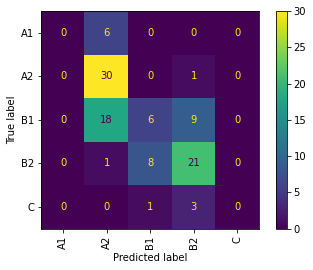

In [27]:
plot_conf_matrix(conf_per_fold[0],['A1','A2','B1','B2','C']) 

##Ausertung

In [28]:
results = pd.DataFrame([model_4,model_5,model_6] ,columns=['konfig','acc','acc_std','qwk', 'qwk_std'])
results.sort_values('qwk')

,konfig,acc,acc_std,qwk,qwk_std
2,RNN (Re),52.831373,2.727838,0.653265,0.055543
0,LSTM (Re),59.541324,0.666825,0.751924,0.005196
1,GRU (Re),61.174384,0.811024,0.760976,0.008065


In [29]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/2_2_2_CNN_RNN_Layer_RE.xlsx', engine='xlsxwriter', index=False)  